In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader

from isqtools import IsqCircuit
from isqtools.backend import TorchBackend
from isqtools.neural_networks import TorchLayer


def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


setup_seed(222)

In [2]:
epochs = 1
train_samples = 200
batch_size_train = 10

test_samples = 100
batch_size_test = 10

device = "cpu"

In [4]:
train_data = torchvision.datasets.MNIST(
    "./data/",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.1307,),
                (0.3081,),
            ),
        ]
    ),
)
test_data = torchvision.datasets.MNIST(
    "./data/",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.1307,),
                (0.3081,),
            ),
        ]
    ),
)

idx = np.append(
    np.where(train_data.targets == 0)[0][:train_samples],
    np.where(train_data.targets == 1)[0][:train_samples],
)

train_data.data = train_data.data[idx]
train_data.targets = train_data.targets[idx]

train_dataloader = DataLoader(
    train_data,
    batch_size=batch_size_train,
    shuffle=True,
)
# 数据 标签 X_train， y_train


idx = np.append(
    np.where(test_data.targets == 0)[0][:test_samples],
    np.where(test_data.targets == 1)[0][:test_samples],
)

test_data.data = test_data.data[idx]
test_data.targets = test_data.targets[idx]

test_dataloader = DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

# 数据 标签 X_test， y_test

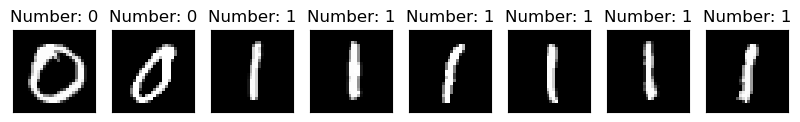

In [5]:
test_plot_data, test_plot_targets = next(iter(test_dataloader))

_, axes = plt.subplots(1, 8, figsize=(10, 3))
for i in range(8):
    axes[i].imshow(test_plot_data[i][0], cmap="gray", interpolation="none")
    axes[i].set_title(f"Number: {test_plot_targets[i]}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])

In [6]:
backend = TorchBackend()

qc = IsqCircuit(
    file="hybrid.isq",
    backend=backend,
    sample=False,
)


def circuit(inputs, weights):
    param = {
        "inputs": inputs,
        "weights": weights,
    }
    result = qc.measure(**param)
    return torch.cat((result[0].view(-1), result[2].view(-1)))


qnn = TorchLayer(
    circuit=circuit,
    num_weights=12,
    is_vmap=True,
)

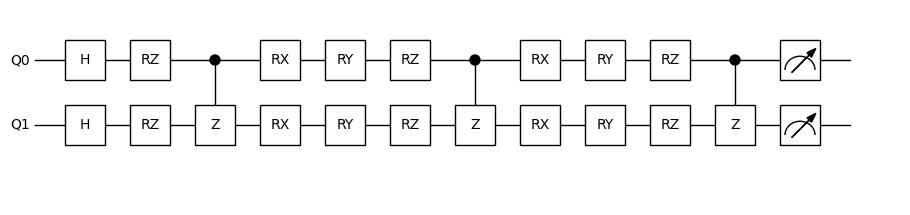

In [7]:
from isqtools.draw import Drawer

dr = Drawer()
dr.plot(qc.qcis)

In [8]:
class HybridNet(nn.Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
        )

        self.fc = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Linear(50, 2),
            qnn,
            nn.Linear(2, 2),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [9]:
hybrid_net = HybridNet(qnn)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(hybrid_net.parameters(), lr=0.001)

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)

    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

In [12]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, hybrid_net, loss_fn, optimizer)
    test(test_dataloader, hybrid_net, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.822773  [   10/  400]
loss: 0.584339  [  110/  400]
loss: 0.547312  [  210/  400]
loss: 0.492907  [  310/  400]
Test Error: 
 Accuracy: 99.5%, Avg loss: 0.493613 

Epoch 2
-------------------------------
loss: 0.521913  [   10/  400]
loss: 0.541909  [  110/  400]
loss: 0.444593  [  210/  400]
loss: 0.484125  [  310/  400]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.455073 

Epoch 3
-------------------------------
loss: 0.465106  [   10/  400]
loss: 0.478267  [  110/  400]
loss: 0.471615  [  210/  400]
loss: 0.465875  [  310/  400]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.427130 

Epoch 4
-------------------------------
loss: 0.424858  [   10/  400]
loss: 0.420086  [  110/  400]
loss: 0.431514  [  210/  400]
loss: 0.420472  [  310/  400]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.396076 

Epoch 5
-------------------------------
loss: 0.414942  [   10/  400]
loss: 0.384991  [  110/  400]
loss: 0.457082  [  210/  400]
loss: 0.377609  [  

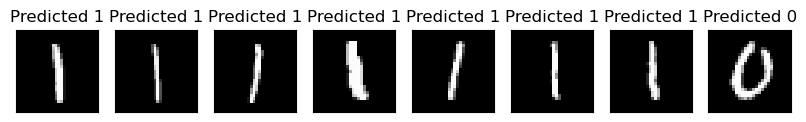

In [13]:
count = 0
_, axes = plt.subplots(1, 8, figsize=(10, 3))
hybrid_net.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_dataloader):
        if count == 8:
            break
        output = hybrid_net(data[0:1])
        pred = output.argmax(dim=1, keepdim=True)
        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray", interpolation="none")
        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title(f"Predicted {pred.item()}")
        count += 1